In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# **1_Загрузка_данных**

In [2]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df.head(4)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

In [4]:
import torch
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim

import os
import time
import glob
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

# **2_Разбивка_данных_train/val**

In [5]:
# Разбивка данных на основе индекса
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.index, test_size=0.5, random_state=99)
# типа разбивка df на train_df и val_df на основе разбивки train_test_split
trn_df, val_df = df[df.index.isin(trn_ids)], df[df.index.isin(val_ids)]
#print(trn_df, val_df)
len(trn_df), len(val_df)

(21000, 21000)

In [16]:
trn_ids, val_ids = train_test_split(trn_df.index, test_size=0.5, random_state=99)
trn_df, val_df = df[df.index.isin(trn_ids)], df[df.index.isin(val_ids)]
len(trn_df), len(val_df)

(656, 656)

In [17]:
# сбрасываем индексы
trn_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [18]:
trn_df.label.value_counts()

label
2    83
6    76
4    72
0    67
1    62
8    62
7    62
9    61
3    58
5    53
Name: count, dtype: int64

In [19]:
val_df.label.value_counts()

label
2    83
7    73
9    68
5    67
1    65
4    64
8    64
0    62
3    57
6    53
Name: count, dtype: int64

**определили trn_df, val_df**

-------------------------------------------------------------------------------

# **3_Компановка_даннх**

(28, 28, 3)


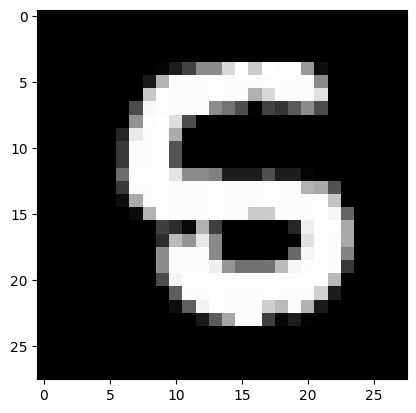

In [13]:
t = np.array(df.iloc[19,1:]).reshape(28,-1)
pic=[]
for i in np.arange(3):
    pic.append(t)
arrImg = np.array(pic).transpose(1, 2, 0)
print(arrImg.shape)

# должен быть массив array, форма (28, 28, 3)
plt.imshow(arrImg)

In [ ]:
# class Asbooka(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.pics = np.array(df.iloc[:,1:])
#         self.targets = np.array(df.iloc[:,0])
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     def __len__(self): return len(self.targets)
#     def __getitem__(self, ix):
        
#         f = self.pics[ix].reshape(28,-1)
#         pic=[]
#         for i in np.arange(3):
#             pic.append(f)
#         im = np.array(torch.tensor(pic).permute(1,2,0))
#         im = cv2.resize(im.astype('float32'), (224,224))
#         im = torch.tensor(im/255)
#         im = im.permute(2,0,1)
#         im = self.normalize(im) 
#         target = self.targets[ix]
#         return im.float(), torch.tensor(target)

In [ ]:
# def get_data():
#     train = Asbooka(trn_df)
#     trn_dl = DataLoader(train, batch_size=64, shuffle=True, drop_last = True)
#     val = Asbooka(val_df)
#     val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
#     return train, trn_dl, val_dl
# train, trn_dl, val_dl = get_data()

In [ ]:
# # train = Asbooka(val_dl)
# for i in train:
#     print(i)
#     break

# **4_Вытаскиваем_модель,_меняем_слои**

In [20]:
from torch.optim import SGD, Adam
import torch.nn as nn
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            model = models.resnet18()
            #------------------------------
            # меняем выходной слой
            model.fc = nn.Linear(in_features=512, out_features=10)
#             model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#             model.fc = nn.Sequential(
#               nn.Flatten(),
#               nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
#               nn.ReLU(inplace=True),
#               nn.Dropout(.2),
#               nn.Linear(128, 1),
#               nn.Sigmoid()
#             )
            #------------------------------
            # замораживаем слои
            freeze_layers = [model.layer1, model.layer2, model.conv1, model.bn1]#, model.layer3]
            for layer in freeze_layers:
               for param in layer.parameters():
                 param.requires_grad = False
            #------------------------------
            self.model = model
        def forward(self, x):
            x = self.model(x)
            return x
    model = neuralnet().model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer
model, loss_fn, optimizer = get_model()

In [ ]:
# глядим замороженные/размороженные слои
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [21]:
model.fc

Linear(in_features=512, out_features=10, bias=True)

-------------------------------------------------------------------

# **Пример вставкт L1 и L2 регуляризации**

In [ ]:
#     outputs=model(inputs)
#     loss=loss_fn(outputs,labels)
    
#     #Replaces pow(2.0) with abs() for L1 regularization
     
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())
 
#     loss = loss + l2_lambda * l2_norm

In [ ]:
# Оптимизатор SGD в PyTorch уже имеет параметр weight_decay, который соответствует L2

---------------------------------------------------------------

# **5_Аугментация**

In [24]:
IMG_SIZE = 28
# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
#     transforms.RandomVerticalFlip(0.4), 
#     transforms.RandomHorizontalFlip(0.4),  
#     transforms.RandomRotation(50,expand=True),
#     transforms.RandomCrop(IMG_SIZE), 
    transforms.ToTensor(), # делится на 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     transforms.Normalize((0.5,), (0.5,))
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(), # divides by 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
   # transforms.Normalize((0.1307,), (0.3081,))
]))

In [27]:
class Asbooka(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        self.pics = np.array(df.iloc[:,1:])
        self.targets = np.array(df.iloc[:,0])
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        picture = self.pics[ix]
#         pic=[]
#         for i in np.arange(3):
#           pic.append(picture)
#         print(pic)
        img = np.array(picture).astype(np.uint8)
        img = np.repeat(img.reshape(28,28,1), 3, axis=2) # делаем форму (28,28,3) из (28,28,1)
#         print(img.shape)
#         print(np.repeat(img.reshape(1,28,28), 3, axis=0).shape)
        if self.transforms:
          img=self.transforms(img)
#         print(img.shape)
        target = self.targets[ix]
        return img, torch.tensor(target)
    

In [28]:
def get_data():
    train = Asbooka(trn_df, train_trans)
    trn_dl = DataLoader(train, batch_size=64, shuffle=True, drop_last = True)
    val = Asbooka(val_df, val_trans)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return train, trn_dl, val_dl
train, trn_dl, val_dl = get_data()

In [29]:
def show_img(img, title):
#   plt.figure(figsize=(20,20))
    npimg=img.numpy().transpose(1,2,0)
    plt.title(title)
    plt.imshow(npimg)#.transpose(1,2,0))
    plt.show()
    
kl = iter(train)

torch.Size([3, 224, 224])


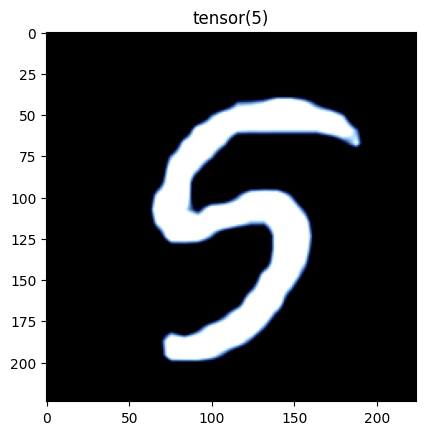

In [34]:
rr = next(kl)
print(rr[0].shape)
show_img(rr[0], rr[1])

-------------------------------------------------

# **5_Функции_для_train_val_вычисляющие_loss_&_accuracy**

In [35]:
def train_batch_loss_acc(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    #-------------------------
    #loss
    batch_loss = loss_fn(prediction, y)
    #-------------------------
    #добавление L1-регуляризации
#     l2_lambda = 0.001
#     l2_norm = sum(p.abs().sum() for p in model.parameters())
#     batch_loss = batch_loss + l2_lambda * l2_norm
    #-------------------------
    #добавление L2-регуляризации
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
#     batch_loss = batch_loss + l2_lambda * l2_norm
    #-------------------------
    #accuracy
    max_values, argmaxes = prediction.max(-1)
    is_correct = np.mean((argmaxes == y).double().numpy())
    #_________________________
#     print(batch_loss)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct

In [36]:
def val_batch_loss_acc(x, y, model, opt, loss_fn):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    #-------------------------
    #loss
    batch_loss = loss_fn(prediction, y)
    #-------------------------
    #accuracy
    max_values, argmaxes = prediction.max(-1)
    is_correct = np.mean((argmaxes == y).double().numpy())
    #_________________________
    return batch_loss.item(), is_correct

In [38]:
# здесь по-моему первого достаточно, добавление второго качество почти не улучшает
from torch.optim.lr_scheduler import StepLR
# scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
scheduler_2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
# scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.1, patience = 3)

# **6_Процесс_обучения**

In [39]:
scheduler_2.get_last_lr()[0]

0.001

In [40]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(16):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(tqdm(trn_dl)):
        x, y = batch
        batch_loss_tr, batch_accuracy_tr = train_batch_loss_acc(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss_tr)
        train_epoch_accuracies.append(batch_accuracy_tr)
        if ix%10 == 0:
            print(f'{ix} batch_train_loss: {np.array(batch_loss_tr)}')
            print(f'{ix} sum_train_loss: {np.array(train_epoch_losses).mean()}')
            print(f'{ix} batch_train_acc: {np.array(batch_accuracy_tr)}')
            print(f'{ix} sum_train_acc: {np.array(train_epoch_accuracies).mean()}', end='\r')
    train_losses.append(np.array(train_epoch_losses).mean())
    train_accuracies.append(np.array(train_epoch_accuracies).mean())
    
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in enumerate(tqdm(val_dl)):
        x, y = batch
        batch_loss_val, batch_accuracy_val = val_batch_loss_acc(x, y, model, optimizer, loss_fn)
        val_epoch_losses.append(batch_loss_val)
        val_epoch_accuracies.append(batch_accuracy_val)
        if ix%10 == 0:
            print(f'{ix} batch_val_loss: {np.array(batch_loss_val)}')
            print(f'{ix} sum_val_loss: {np.array(val_epoch_losses).mean()}')
            print(f'{ix} batch_val_acc: {np.array(batch_accuracy_val)}')
            print(f'{ix} sum_val_acc: {np.array(val_epoch_accuracies).mean()}', end='\r')
    #---------------------------------
    # изменение шага
#     scheduler_2.step() # меняем_шаг
#     print(scheduler_2.get_last_lr()[0]) # выводим_значение_шага
    #---------------------------------    
    val_losses.append(np.array(val_epoch_losses).mean())
    val_accuracies.append(np.array(val_epoch_accuracies).mean())

    
    print(f'train_losses: {train_losses}, train_accuracies: {train_accuracies}')
    print(f'val_losses: {val_losses}, val_accuracies: {val_accuracies}')

0


 10%|█         | 1/10 [00:06<00:55,  6.14s/it]

0 batch_train_loss: 2.31449031829834
0 sum_train_loss: 2.31449031829834
0 batch_train_acc: 0.109375


  5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

0 batch_val_loss: 3.907841682434082
0 sum_val_loss: 3.907841682434082
0 batch_val_acc: 0.34375


 55%|█████▌    | 11/20 [00:15<00:12,  1.38s/it]

10 batch_val_loss: 3.345374822616577
10 sum_val_loss: 4.470444614237005
10 batch_val_acc: 0.34375


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


train_losses: [1.478419727087021], train_accuracies: [0.4953125]
val_losses: [4.55375691652298], val_accuracies: [0.2390625]
1


 10%|█         | 1/10 [00:05<00:49,  5.45s/it]

0 batch_train_loss: 0.5745223164558411
0 sum_train_loss: 0.5745223164558411
0 batch_train_acc: 0.796875


  5%|▌         | 1/20 [00:01<00:25,  1.36s/it]

0 batch_val_loss: 7.622189044952393
0 sum_val_loss: 7.622189044952393
0 batch_val_acc: 0.125


 55%|█████▌    | 11/20 [00:14<00:12,  1.36s/it]

10 batch_val_loss: 7.203553199768066
10 sum_val_loss: 7.76690114628185
10 batch_val_acc: 0.25


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


train_losses: [1.478419727087021, 0.4097021609544754], train_accuracies: [0.4953125, 0.8984375]
val_losses: [4.55375691652298, 7.872489738464355], val_accuracies: [0.2390625, 0.175]
2


 10%|█         | 1/10 [00:05<00:48,  5.34s/it]

0 batch_train_loss: 0.23404942452907562
0 sum_train_loss: 0.23404942452907562
0 batch_train_acc: 0.96875


  5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

0 batch_val_loss: 6.032670021057129
0 sum_val_loss: 6.032670021057129
0 batch_val_acc: 0.25


 55%|█████▌    | 11/20 [00:14<00:12,  1.35s/it]

10 batch_val_loss: 6.947883605957031
10 sum_val_loss: 6.447551770643755
10 batch_val_acc: 0.1875


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507], train_accuracies: [0.4953125, 0.8984375, 0.9640625]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576], val_accuracies: [0.2390625, 0.175, 0.21875]
3


 10%|█         | 1/10 [00:06<00:54,  6.04s/it]

0 batch_train_loss: 0.10330278426408768
0 sum_train_loss: 0.10330278426408768
0 batch_train_acc: 0.984375


  5%|▌         | 1/20 [00:01<00:25,  1.32s/it]

0 batch_val_loss: 3.891657590866089
0 sum_val_loss: 3.891657590866089
0 batch_val_acc: 0.21875


 55%|█████▌    | 11/20 [00:15<00:12,  1.40s/it]

10 batch_val_loss: 3.7426376342773438
10 sum_val_loss: 3.448664990338412
10 batch_val_acc: 0.21875


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25]
4


 10%|█         | 1/10 [00:05<00:48,  5.37s/it]

0 batch_train_loss: 0.03637164831161499
0 sum_train_loss: 0.03637164831161499
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:26,  1.41s/it]

0 batch_val_loss: 0.5142151117324829
0 sum_val_loss: 0.5142151117324829
0 batch_val_acc: 0.78125


 55%|█████▌    | 11/20 [00:15<00:12,  1.37s/it]

10 batch_val_loss: 0.38857683539390564
10 sum_val_loss: 0.3221843141046437
10 batch_val_acc: 0.90625


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125]
5


 10%|█         | 1/10 [00:05<00:48,  5.34s/it]

0 batch_train_loss: 0.009031803347170353
0 sum_train_loss: 0.009031803347170353
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

0 batch_val_loss: 0.5868769884109497
0 sum_val_loss: 0.5868769884109497
0 batch_val_acc: 0.78125


 55%|█████▌    | 11/20 [00:15<00:11,  1.33s/it]

10 batch_val_loss: 1.0588401556015015
10 sum_val_loss: 1.014520981095054
10 batch_val_acc: 0.78125


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125]
6


 10%|█         | 1/10 [00:05<00:47,  5.31s/it]

0 batch_train_loss: 0.005442248657345772
0 sum_train_loss: 0.005442248657345772
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

0 batch_val_loss: 0.5165045261383057
0 sum_val_loss: 0.5165045261383057
0 batch_val_acc: 0.875


 55%|█████▌    | 11/20 [00:14<00:12,  1.39s/it]

10 batch_val_loss: 0.7089923024177551
10 sum_val_loss: 0.57655423337763
10 batch_val_acc: 0.78125


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875]
7


 10%|█         | 1/10 [00:05<00:48,  5.39s/it]

0 batch_train_loss: 0.003006493439897895
0 sum_train_loss: 0.003006493439897895
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

0 batch_val_loss: 0.12581203877925873
0 sum_val_loss: 0.12581203877925873
0 batch_val_acc: 0.9375


 55%|█████▌    | 11/20 [00:14<00:12,  1.34s/it]

10 batch_val_loss: 0.21333403885364532
10 sum_val_loss: 0.21063560382886368
10 batch_val_acc: 0.9375


100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375]
8


 10%|█         | 1/10 [00:05<00:52,  5.80s/it]

0 batch_train_loss: 0.002768745180219412
0 sum_train_loss: 0.002768745180219412
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:24,  1.31s/it]

0 batch_val_loss: 0.42169374227523804
0 sum_val_loss: 0.42169374227523804
0 batch_val_acc: 0.90625


 55%|█████▌    | 11/20 [00:15<00:12,  1.37s/it]

10 batch_val_loss: 0.4058518409729004
10 sum_val_loss: 0.25928806039420044
10 batch_val_acc: 0.875


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875]
9


 10%|█         | 1/10 [00:05<00:46,  5.22s/it]

0 batch_train_loss: 0.0023481009993702173
0 sum_train_loss: 0.0023481009993702173
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

0 batch_val_loss: 0.11293616145849228
0 sum_val_loss: 0.11293616145849228
0 batch_val_acc: 0.96875


 55%|█████▌    | 11/20 [00:14<00:11,  1.33s/it]

10 batch_val_loss: 0.5063952207565308
10 sum_val_loss: 0.1532434138723395
10 batch_val_acc: 0.84375


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625]
10


 10%|█         | 1/10 [00:05<00:47,  5.27s/it]

0 batch_train_loss: 0.001363693387247622
0 sum_train_loss: 0.001363693387247622
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:26,  1.39s/it]

0 batch_val_loss: 0.0520658865571022
0 sum_val_loss: 0.0520658865571022
0 batch_val_acc: 0.96875


 55%|█████▌    | 11/20 [00:15<00:12,  1.34s/it]

10 batch_val_loss: 0.10612140595912933
10 sum_val_loss: 0.14405894855206663
10 batch_val_acc: 0.96875


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625]
11


 10%|█         | 1/10 [00:05<00:47,  5.25s/it]

0 batch_train_loss: 0.0011030016466975212
0 sum_train_loss: 0.0011030016466975212
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.36s/it]

0 batch_val_loss: 0.24045255780220032
0 sum_val_loss: 0.24045255780220032
0 batch_val_acc: 0.9375


 55%|█████▌    | 11/20 [00:14<00:12,  1.34s/it]

10 batch_val_loss: 0.06933049112558365
10 sum_val_loss: 0.12383409352465109
10 batch_val_acc: 0.96875


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567, 0.000977875740500167], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083, 0.12306844268459827], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625, 0.965625]
12


 10%|█         | 1/10 [00:05<00:47,  5.33s/it]

0 batch_train_loss: 0.0008123745210468769
0 sum_train_loss: 0.0008123745210468769
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

0 batch_val_loss: 0.0653926357626915
0 sum_val_loss: 0.0653926357626915
0 batch_val_acc: 0.96875


 55%|█████▌    | 11/20 [00:14<00:11,  1.32s/it]

10 batch_val_loss: 0.05781980976462364
10 sum_val_loss: 0.11550218637355349
10 batch_val_acc: 0.96875


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567, 0.000977875740500167, 0.0007919937197584659], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083, 0.12306844268459827, 0.11730634849518537], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625, 0.965625, 0.9640625]
13


 10%|█         | 1/10 [00:05<00:46,  5.17s/it]

0 batch_train_loss: 0.000746911799069494
0 sum_train_loss: 0.000746911799069494
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

0 batch_val_loss: 0.14332708716392517
0 sum_val_loss: 0.14332708716392517
0 batch_val_acc: 0.96875


 55%|█████▌    | 11/20 [00:14<00:11,  1.31s/it]

10 batch_val_loss: 0.06986244022846222
10 sum_val_loss: 0.13590889949012885
10 batch_val_acc: 0.96875


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567, 0.000977875740500167, 0.0007919937197584659, 0.0007893759349826724], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083, 0.12306844268459827, 0.11730634849518537, 0.1198760936036706], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625, 0.965625, 0.9640625, 0.9640625]
14


 10%|█         | 1/10 [00:05<00:46,  5.17s/it]

0 batch_train_loss: 0.0006258364301174879
0 sum_train_loss: 0.0006258364301174879
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

0 batch_val_loss: 0.21605312824249268
0 sum_val_loss: 0.21605312824249268
0 batch_val_acc: 0.875


 55%|█████▌    | 11/20 [00:14<00:11,  1.32s/it]

10 batch_val_loss: 0.013952970504760742
10 sum_val_loss: 0.10423875828696923
10 batch_val_acc: 1.0


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567, 0.000977875740500167, 0.0007919937197584659, 0.0007893759349826724, 0.0006783812976209446], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083, 0.12306844268459827, 0.11730634849518537, 0.1198760936036706, 0.11843156307004392], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625, 0.965625, 0.9640625, 0.9640625, 0.965625]
15


 10%|█         | 1/10 [00:05<00:47,  5.33s/it]

0 batch_train_loss: 0.0005145145696587861
0 sum_train_loss: 0.0005145145696587861
0 batch_train_acc: 1.0


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

0 batch_val_loss: 0.009038097225129604
0 sum_val_loss: 0.009038097225129604
0 batch_val_acc: 1.0


 55%|█████▌    | 11/20 [00:14<00:11,  1.31s/it]

10 batch_val_loss: 0.21184048056602478
10 sum_val_loss: 0.0958036555993286
10 batch_val_acc: 0.9375


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

train_losses: [1.478419727087021, 0.4097021609544754, 0.16442424319684507, 0.05504581518471241, 0.021946452930569647, 0.011962860031053424, 0.006571596395224333, 0.004077499592676758, 0.002513182209804654, 0.0018698271946050228, 0.0013661812525242567, 0.000977875740500167, 0.0007919937197584659, 0.0007893759349826724, 0.0006783812976209446, 0.0008184429549146444], train_accuracies: [0.4953125, 0.8984375, 0.9640625, 0.996875, 0.9984375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_losses: [4.55375691652298, 7.872489738464355, 6.532817101478576, 3.2917207360267637, 0.33113479278981683, 1.0896066844463348, 0.5478487581014633, 0.19971852824091912, 0.25181988030672076, 0.1355350404046476, 0.14539859232027083, 0.12306844268459827, 0.11730634849518537, 0.1198760936036706, 0.11843156307004392, 0.1169329381082207], val_accuracies: [0.2390625, 0.175, 0.21875, 0.25, 0.8953125, 0.7125, 0.846875, 0.934375, 0.921875, 0.9640625, 0.95625, 0.965625, 0.9640625, 0.9640625, 0.965625, 0.96562

# **7_Вывод_результатов**

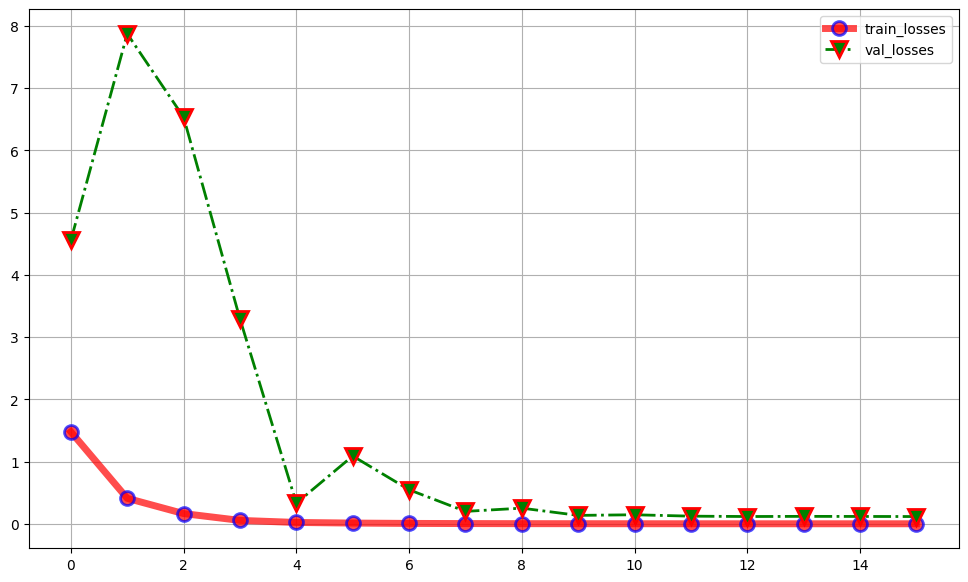

In [41]:
x = np.arange(0,16)
y1 = train_losses
y2 = val_losses
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="train_losses", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="val_losses", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

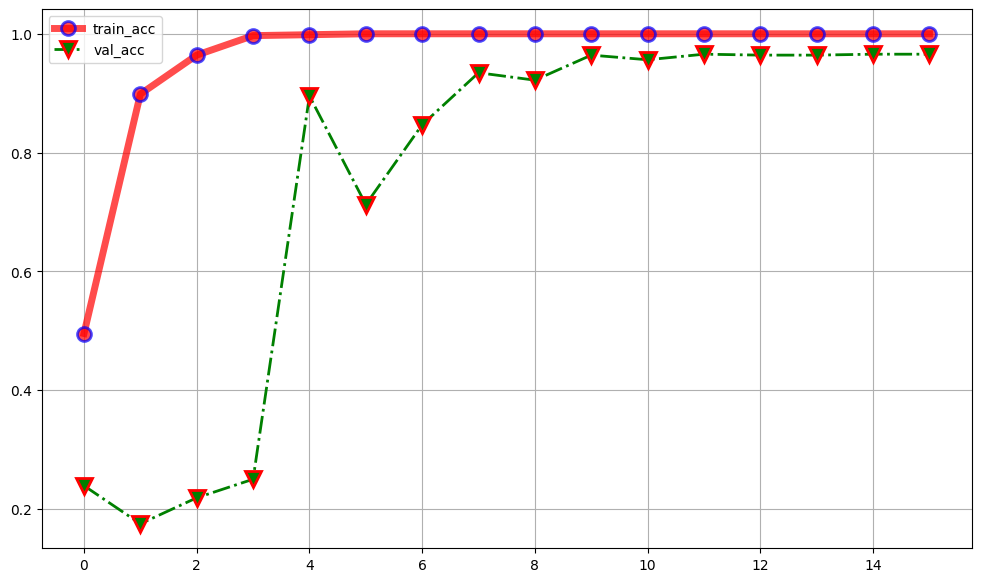

In [42]:
x = np.arange(0,16)
y1 = train_accuracies
y2 = val_accuracies
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="train_acc", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="val_acc", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

# **8_Предсказание**

In [51]:
# random выбор картинок
df_test = df.sample(6)
df_test

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
7015,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5484,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
330,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4000,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35761,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


tensor([8, 5, 2, 0, 6, 4])


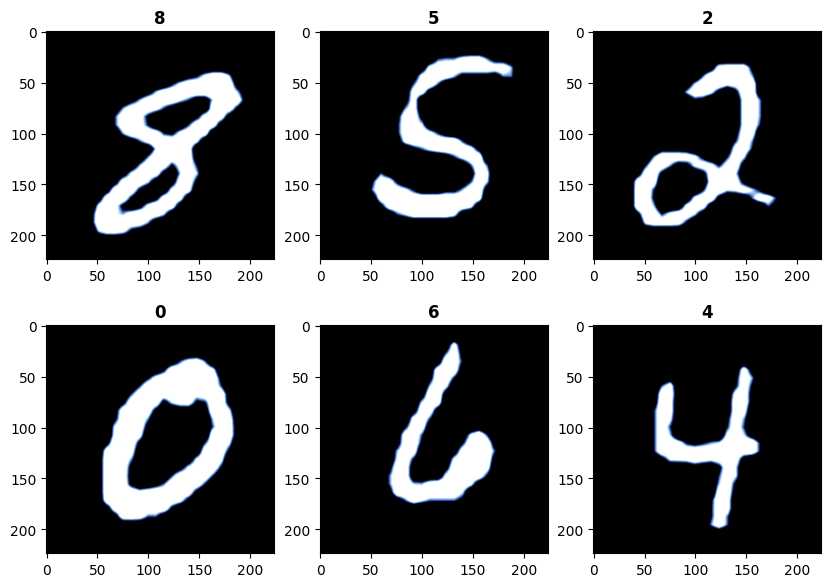

In [54]:
# преобразования для подачи в модель
t = Asbooka(df_test, val_trans)
t_dl = DataLoader(t, batch_size=6, shuffle=True, drop_last = True)

# разделяем картинки и true
for i in t_dl:
    x,y = i
#     print(x)
    print(y)
    
# блок предсказания класса
@torch.no_grad()
def pred(x, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    pred_list = prediction.max(1)[1].detach().numpy()
    return x.numpy(), pred_list

# делаем список картинка + предсказание
images, predictions = pred(x, model)
data = list(zip(images, predictions))

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
axs = [ax[i, j] for i in range(2) for j in range(3)]
for _,i in enumerate(data):
    axs[_].set_title(i[1], fontweight ="bold")
    axs[_].imshow(i[0].transpose(1, 2, 0))
#     arrImg = i[0].transpose(1, 2, 0)
#     plt.title(i[1], fontweight ="bold") 
#     plt.imshow(arrImg)